# Tutorial Presentation at ASE2021

This demo is presented at the International Conference on Automated Software (ASE) 2021.
For background and details, please refer to this slide (*TBU*).

In [1]:
# Define global functions for this tutorial

def generate_heatmap(X_input):
    corrmat = X_input.corr(method='spearman')
    top_corr_features = corrmat.index


    # Visualise a lower-triangle correlation heatmap
    mask_df = np.triu(np.ones(corrmat.shape)).astype(np.bool)
    plt.figure(figsize=(10,8))
    #plot heat map
    g=sns.heatmap(X_input[top_corr_features].corr(), 
                  mask = mask_df, 
                  vmin = -1,
                  vmax = 1,
                  annot=False,
                  cmap="RdBu")


## Part 1: Introduction to Explainable AI

Please refer to Pages XX to YY of the slides.

## Part 2: Defect Prediction Models

Below, we describe five key data analytics steps of developing an explainable defect prediction model (i.e., a prediction model to predict software defects) {cite}`tantithamthavorn2018pitfalls`: (1) Data Collection, (2) Data Preprocessing, (3) Model Construction, (4) Model Evaluation, and (5) Model Ranking.

### (Step 1) Data Collection

Data collection involves several key steps.
{numref}`data-preparation` provides an overview of defect data preparation steps.
First, one must extract issue reports, which describe defects, feature requests, or general maintenance tasks from an Issue Tracking System (ITS, e.g., JIRA).
Second, one must extract commit logs, code snapshots, and historical code changes that are recorded in a Version Control System (VCS, e.g., Git).
Third, one must extract software metrics of each module (e.g., size, and complexity) from the VCS.
To extract such software metrics, one must focus on development activities that occur prior to a release of interest that corresponds to the release branch of a studied system to ensure that activities that we study correspond to the development and maintenance of the official software releases. 
Finally, one must identify and label modules as defective if they have been affected by code changes that address issue reports that were classified as defects after the software is released (i.e., post-release defects).
On the other hand, modules that are not changed to address any issue reports are labelled as clean.

```{figure} /defect-prediction/images/data-preparation.png
---
name: data-preparation
---
An overview of defect data preparation steps.
```
#### Software Metrics

To prepare a defect dataset, we first *extract metrics* of software modules (e.g., size, complexity, process metrics) from a version control system (VCS).
We focus on the development activity that occurs prior to a release that corresponds to the *release* branch of a studied system. 
With this strictly controlled setting, we ensure that changes that we study correspond to the development and maintenance of official software releases.
Since modern issue tracking systems, like JIRA, often provide traceable links between issue reports (i.e., a report described defects or feature requests) and code changes, we can identify the modules that are changed to address a particular issue report.
Finally, we *label defective modules* if they have been affected by a code change that addresses an issue report that is classified as a defect.
Similar to prior studies {cite}`zimmermann2007predicting,Ambros,Kamei2013`, we define post-release defects as modules that are changed to address an issue report within the six-month period after the release date.

To understand the characteristics of defect-proneness, prior studies proposed a variety of metrics that are related to software quality.
We provide a brief summary of software metrics below.

**Code metrics** describe the relationship between code properties and software quality.
For example, in 1971, Akiyama {cite}`akiyama1971example` is among the first research to show that the size of modules (e.g., lines of code) shares a relationship with defect-proneness. 
McCabe et al. {cite}`mccabe1976complexity` and Halstead also show that the high complexity of modules (e.g., the number of distinct operators and operands) are likely to be more defective.
Chidamber and Kemerer {cite}`chidamber1994metrics` also propose CK metrics suites, a set of six metrics that describe the structure of a class (e.g., the number of methods defined in a class), that may share a relationship with defect-proneness.
An independent evaluation by Basili et al. {cite}`basili1996validation` and Gyimothy et al. {cite}`gyimothy2005empirical` confirms that the CK metrics suites can be effectively used as software quality indicators.
An in-depth investigation on the size-defect relationship by Syer {cite}`syer2014replicating` shows that defect density has an inverted "U" shaped pattern (i.e., defect density increases in smaller files, peaks in the largest small-sized files/smallest medium-sized files, then decreases in medium and larger files).
Such code metrics are typically extracted from a code snapshot at a release using various available static analysis tools (e.g., [SLOCcount](https://sourceforge.net/projects/sloccount/) tool, [Understand](https://scitools.com/) tool , the [*mccabe*](https://pypi.python.org/pypi/mccabe) python package, and the [*radon*](https://pypi.python.org/pypi/radon) python package).

**Process metrics** describe the relationship between change activities during software development process and software quality. 
Prior work has shown that historical software development process can be used to describe the characteristics of defect-proneness.
For example, Graves {cite}`Graves2000` find that the software defects may still exist in modules that were recently defective.
Nagappan and Ball {cite}`Nagappan2005,nagappan2007using` find that modules that have undergone a lot of change are likely to be more defective.
Hassan {cite}`hassan2009predicting` find that modules with a volatile change process, where changes are spread amongst several files are likely defective.
Hassan and Holt {cite}`Hassan2005` find that modules that are recently changed are more likely to be defective.
Zimmermann and Nagappan {cite}`Zimmermann2009,Zimmermann2008,zimmermann2007predicting` find that program dependency graphs share a relationship with software quality.
Zimmermann et al. {cite}`zimmermann2007predicting` find that the number of defects that were reported in the last six months before release for a module shares a relationship with software quality.
Such process metrics are typically extracted using code changes that are stored in VCSs.


**Organization metrics** describe the relationship between organization structure and software quality {cite}`nagappan2008influence`.
For example, Graves et al. {cite}`Graves2000` find that modules that are changed by a large number of developers are likely to be more defective.
Despite of the organization structure, prior studies have shown that code ownership shares a relationship with software quality.
Thus, we focus on the two dimensions for an approximation of code ownership.
First, *authoring activity* has been widely used to approximate code ownership.
For example, Mockus and Herbslerb {cite}`mockus2002expertise` identify developers who responsible for a module using the number of tasks that a developer has completed.
Furthermore, Bird et al. {cite}`Bird2011a` find that modules that are written by many experts are less likely to be defect-prone.
Second, *reviewing activity* has been also used to approximate code ownership.
For example, Thongtanunam {cite}`thongtanunam2016revisiting` find that reviewing expertise also shares a relationship with defect-proneness (e.g., modules that are reviewed by experts are less likely to be defect-prone). 

In this tutorial, we provide 2 example datasets of Apache Lucene Releases 2.9.0 and 3.0.0.
Each dataset consists of 65 software metrics (independent variables) and defect labels indicating whether a file is defective (dependent variable).


In [2]:
## Load Data and preparing datasets

# Import for Load Data
from os import listdir
from os.path import isfile, join
import pandas as pd
# Import for Split Data into Training and Testing Samples
from sklearn.model_selection import train_test_split
import numpy as np

lucene_290_dataset = pd.read_csv(("../../datasets/lucene-2.9.0.csv"), index_col = 'File')
lucene_300_dataset = pd.read_csv(("../../datasets/lucene-3.0.0.csv"), index_col = 'File')

outcome = 'RealBug'
metrics = lucene_290_dataset.columns[:-1]

In [3]:
display(lucene_290_dataset)

,CountDeclMethodPrivate,AvgLineCode,CountLine,MaxCyclomatic,CountDeclMethodDefault,AvgEssential,CountDeclClassVariable,SumCyclomaticStrict,AvgCyclomatic,AvgLine,...,DDEV,Added_lines,Del_lines,OWN_LINE,OWN_COMMIT,MINOR_COMMIT,MINOR_LINE,MAJOR_COMMIT,MAJOR_LINE,RealBug
File,,,,,,,,,,,,,,,,,,,,,
contrib/analyzers/common/src/java/org/apache/lucene/analysis/ar/ArabicAnalyzer.java,0,7,157,2,0,1,2,8,1,12,...,2,172,15,0.745223,0.750000,0,2,2,0,True
contrib/analyzers/common/src/java/org/apache/lucene/analysis/ar/ArabicLetterTokenizer.java,0,3,54,1,0,1,0,5,1,4,...,3,55,1,0.777778,0.333333,0,3,3,0,False
contrib/analyzers/common/src/java/org/apache/lucene/analysis/ar/ArabicNormalizationFilter.java,0,7,51,2,0,1,0,3,2,7,...,3,65,14,0.764706,0.333333,0,2,3,1,False
contrib/analyzers/common/src/java/org/apache/lucene/analysis/ar/ArabicNormalizer.java,0,10,102,6,0,1,17,18,4,21,...,1,102,0,1.000000,1.000000,0,1,1,0,False
contrib/analyzers/common/src/java/org/apache/lucene/analysis/ar/ArabicStemFilter.java,0,7,51,2,0,1,0,3,2,7,...,3,73,22,0.764706,0.333333,0,2,3,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
src/test/org/apache/lucene/util/TestRamUsageEstimator.java,0,7,57,1,2,1,0,3,1,8,...,1,57,0,1.000000,1.000000,0,1,1,0,False
src/test/org/apache/lucene/util/TestSmallFloat.java,0,13,112,5,2,2,0,12,3,15,...,0,0,0,0.991071,0.000000,0,1,0,1,False
src/test/org/apache/lucene/util/TestSortedVIntList.java,4,5,196,5,2,1,5,45,2,5,...,2,6,8,0.969388,0.500000,0,1,2,2,False


### (Step 2) Data Preprocessing

Data preprocessing is essential to ensure the quality of the produced defect prediction models and their explanations.
Prior work {cite}`jiarpakdee2018impact` found that strong correlations among software metrics (e.g., collinearity and multicollinearity) negatively impact the explanations produced by defect prediction models, leading to misleading and unstable conclusions of defect prediction models.
Therefore, ones must mitigate strong correlations among software metrics prior to constructing defect prediction models to generate reliable explanations.

In this tutorial, we first illustrate steps to detect two levels of correlations: collinearity and multicollinearity.
After detecting collinearity and multicollinearity, we provides an introductory step of data preprocessing to mitigate collinearity and multicollinearity.

#### Detecting Collinearity

Collinearity is a phenomenon in which one metric can be linearly predicted by another metric. 
There are several correlation tests that can detect collinearity between metrics. 
For example, Pearson correlation test, Spearman correlation test, and Kendall Tau correlation test.
Below, we provide a tutorial for using and visualising Spearman correlation test.
In this tutorial, we use the interpretation of Spearman correlation coefficients ($|\rho|$) as
provided by Kraemer {cite}`kraemer2003measures`---i.e., a Spearman
correlation coefficient of above or equal to 0.7 is considered a strong
correlation.

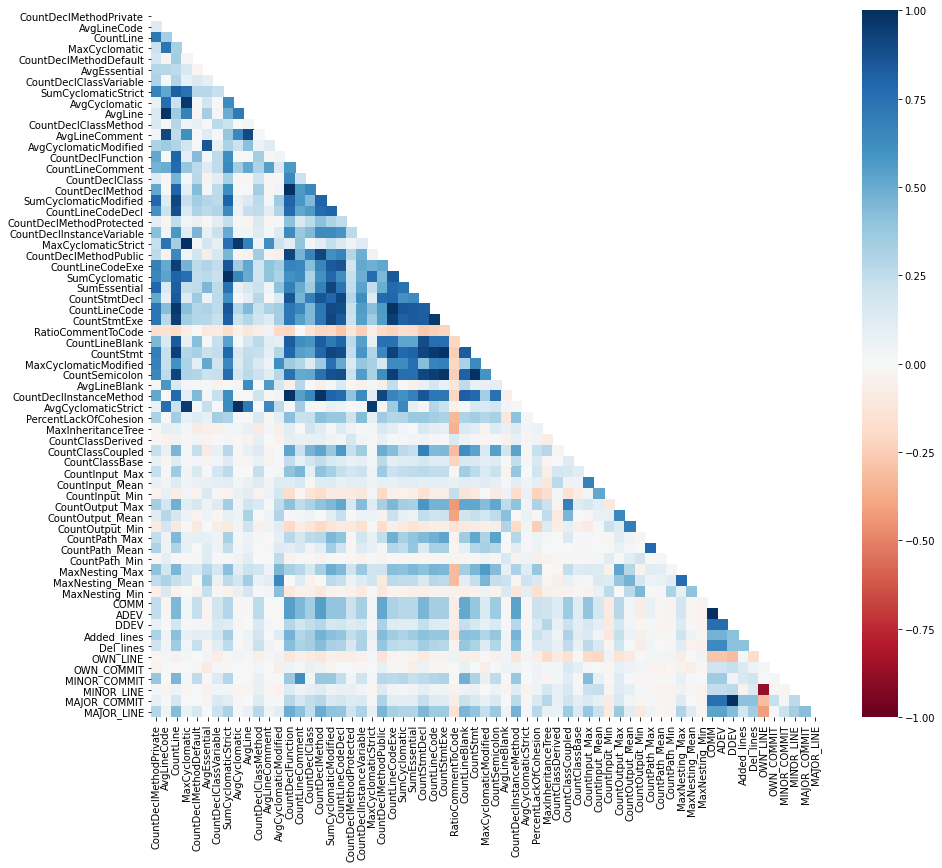

In [4]:
# Import for Correlation tests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Prepare a dataframe for collinearity simulation
Dataset_Corr = lucene_290_dataset.copy()
X_Corr = Dataset_Corr.loc[:, metrics]

# There are 3 options for the parameter setting of method as follows:
# pearson : standard correlation coefficient
# kendall : Kendall Tau correlation coefficient
# spearman : Spearman rank correlation
corrmat = X_Corr.corr(method='spearman')
top_corr_features = corrmat.index


# Visualise a lower-triangle correlation heatmap
mask_df = np.triu(np.ones(corrmat.shape)).astype(np.bool)
plt.figure(figsize=(15,13))
#plot heat map
g=sns.heatmap(X_Corr[top_corr_features].corr(), 
              mask = mask_df, 
              vmin = -1,
              vmax = 1,
              annot=False,
              cmap="RdBu")

In [5]:
# compute absolute metric correlation
abs_corrmat = abs(corrmat)

# identify correlated metrics with the correlation threshold of 0.7
highly_correlated_metrics = pd.melt(abs_corrmat, ignore_index = False)
highly_correlated_metrics.reset_index(inplace = True)
highly_correlated_metrics = highly_correlated_metrics[highly_correlated_metrics['value'] != 1]
highly_correlated_metrics = highly_correlated_metrics[highly_correlated_metrics['value'] >= 0.7]
highly_correlated_metrics = set(np.append(highly_correlated_metrics['index'].values, highly_correlated_metrics['variable'].values))

print('# of correlated metrics (Collinearity) with absolute Spearman Correlation Coefficients of above 0.7:', len(highly_correlated_metrics))

# of correlated metrics (Collinearity) with absolute Spearman Correlation Coefficients of above 0.7: 47


In [6]:
set(highly_correlated_metrics)

{'ADEV',
 'Added_lines',
 'AvgCyclomatic',
 'AvgCyclomaticModified',
 'AvgCyclomaticStrict',
 'AvgLine',
 'AvgLineCode',
 'AvgLineComment',
 'COMM',
 'CountClassCoupled',
 'CountDeclFunction',
 'CountDeclInstanceMethod',
 'CountDeclMethod',
 'CountDeclMethodPublic',
 'CountInput_Max',
 'CountInput_Mean',
 'CountLine',
 'CountLineBlank',
 'CountLineCode',
 'CountLineCodeDecl',
 'CountLineCodeExe',
 'CountLineComment',
 'CountOutput_Max',
 'CountOutput_Mean',
 'CountPath_Max',
 'CountPath_Mean',
 'CountPath_Min',
 'CountSemicolon',
 'CountStmt',
 'CountStmtDecl',
 'CountStmtExe',
 'DDEV',
 'Del_lines',
 'MAJOR_COMMIT',
 'MINOR_LINE',
 'MaxCyclomatic',
 'MaxCyclomaticModified',
 'MaxCyclomaticStrict',
 'MaxNesting_Max',
 'MaxNesting_Mean',
 'MaxNesting_Min',
 'OWN_LINE',
 'RatioCommentToCode',
 'SumCyclomatic',
 'SumCyclomaticModified',
 'SumCyclomaticStrict',
 'SumEssential'}

#### Detecting Multicollinearity


Multicollinearity is a phenomenon in which one metric can be linearly predicted by a combination of two or more metrics. 
Multicollinearity can be detected using Variance Inflation Factor (VIF) analysis {cite}`fox1992generalized`.
The idea behind variance inflation factor analysis is to construct an ordinary least square regression to predict a metric by using the other metrics in the dataset.
Having a model that is well fit indicates that the metric can be predicted by other metrics, linearly highly-correlated with other metrics.
There are 3 steps in variance inflation factor analysis.

*(Step 1) Construct a regression model for each metric.*
For each metric, we construct a model using the other metrics to predict that particular metric.

*(Step 2) Compute a VIF score for each metric.*
The VIF score for each metric is computed using the following formula: $\mathrm{VIF} = \frac{1}{1 - \mathrm{R}^2}$, where $\mathrm{R}^2$ is the explanatory power of the regression model from Step 1.
A high VIF score of a metric indicates that a given metric can be accurately predicted by the other metrics.
Thus, that given metric is considered redundant and should be removed from our model.

*(Step 3) Remove metrics with a VIF score that is higher than a given threshold.*
We remove metrics with a VIF score that is higher than a given threshold.
We use a VIF threshold of 5 to determine the magnitude of multi-collinearity, as it is suggested by Fox {cite}`fox2015applied`.
Then, we repeat the above three steps until the VIF scores of all remaining metrics are lower than the pre-defined threshold.


In [7]:
# Import for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


# Prepare a dataframe for VIF
X_VIF = add_constant(X_Corr)

# Calculate VIF scores
vif_scores = pd.DataFrame([variance_inflation_factor(X_VIF.values, i) 
               for i in range(X_VIF.shape[1])], 
              index=X_VIF.columns)
# Prepare a final dataframe of VIF scores and select only those that have vif scores of above 5
vif_scores.reset_index(inplace = True)
vif_scores.columns = ['Metric', 'VIFscore']
vif_scores = vif_scores.loc[vif_scores['Metric'] != 'const', :]
vif_scores = vif_scores.sort_values(by = ['VIFscore'], ascending = False)
vif_scores = vif_scores[vif_scores['VIFscore'] >= 5]

/opt/anaconda3/envs/xaitools/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [8]:
print('# of correlated metrics (Multicollinearity) with VIF scores of above 5:', len(vif_scores))

# of correlated metrics (Multicollinearity) with VIF scores of above 5: 46


In [9]:
display(vif_scores)

,Metric,VIFscore
1,CountDeclMethodPrivate,inf
57,DDEV,inf
32,CountStmt,inf
36,CountDeclInstanceMethod,inf
29,CountStmtExe,inf
27,CountStmtDecl,inf
23,CountDeclMethodPublic,inf
55,COMM,inf
20,CountDeclMethodProtected,inf
56,ADEV,inf


#### AutoSpearman: An automated feature selection approach that address collinearity and multicollinearity


Jiarpakdee *et al.* {cite}`jiarpakdee2018icsme`{cite}`jiarpakdee2020impactfss` {cite}`jiarpakdee2018autospearman` introduce , an
automated metric selection approach based on the Spearman rank
correlation test and the VIF analysis for statistical inference. 
The high-level concept of can be summarised into 2 parts:

*(Part 1) Automatically select non-correlated metrics based on a
Spearman rank correlation test.* We first measure the correlation of all
metrics using the Spearman rank correlation test ($\rho$). We use the interpretation of correlation coefficients ($|\rho|$) as
provided by Kraemer {cite}`kraemer2003measures`---i.e., a Spearman
correlation coefficient of above or equal to 0.7 is considered a strong
correlation. Thus, we only consider the pairs that have an absolute
Spearman correlation coefficient of above or equal to the threshold
value ($sp.t$) of 0.7.

To automatically select non-correlated metrics based on the Spearman
rank correlation test, we start from the pair that has the highest
Spearman correlation coefficient. Since the two
correlated metrics under examination can be linearly predicted with each
other, one of these two metrics must be removed. Thus, we select the
metric that has the lowest average values of the absolute Spearman
correlation coefficients of the other metrics that are not included in
the pair. That means the removed metric is another metric
in the pair that is not selected. Since the removed
metric may be correlated with the other metrics, we remove any pairs of
metrics that are correlated with the removed metric.
Finally, we exclude the removed metric from the set of the remaining
metrics ($M'$). We repeat this process until all pairs of
metrics have their Spearman correlation coefficient below a threshold
value of 0.7.


In [10]:

# Prepare a dataframe for AutoSpearman demo
Dataset_AS = lucene_290_dataset.copy()
X_AS = Dataset_AS.loc[:, metrics]

AS_metrics = metrics
count = 1

# (Part 1) Automatically select non-correlated metrics based on a Spearman rank correlation test.
print('(Part 1) Automatically select non-correlated metrics based on a Spearman rank correlation test')
while True:
    corrmat = X_AS.corr(method='spearman')
    top_corr_features = corrmat.index
    abs_corrmat = abs(corrmat)
    
    # identify correlated metrics with the correlation threshold of 0.7
    highly_correlated_metrics = ((corrmat > .7) | (corrmat < -.7)) & (corrmat != 1)
    n_correlated_metrics = np.sum(np.sum(highly_correlated_metrics))
    if n_correlated_metrics > 0:
        # find the strongest pair-wise correlation
        find_top_corr = pd.melt(abs_corrmat, ignore_index = False)
        find_top_corr.reset_index(inplace = True)
        find_top_corr = find_top_corr[find_top_corr['value'] != 1]
        top_corr_index = find_top_corr['value'].idxmax()
        top_corr_i = find_top_corr.loc[top_corr_index, :]

        # get the 2 correlated metrics with the strongest correlation
        correlated_metric_1 = top_corr_i[0]
        correlated_metric_2 = top_corr_i[1]
        print('Step', count,'comparing between', correlated_metric_1, 'and', correlated_metric_2)
        
        # compute their correlation with other metrics outside of the pair
        correlation_with_other_metrics_1 = np.mean(abs_corrmat[correlated_metric_1][[i for i in top_corr_features if i not in [correlated_metric_1, correlated_metric_2]]])
        correlation_with_other_metrics_2 = np.mean(abs_corrmat[correlated_metric_2][[i for i in top_corr_features if i not in [correlated_metric_1, correlated_metric_2]]])
        print('>', correlated_metric_1, 'has the average correlation of', np.round(correlation_with_other_metrics_1, 3), 'with other metrics')
        print('>', correlated_metric_2, 'has the average correlation of', np.round(correlation_with_other_metrics_2,3) , 'with other metrics')
        # select the metric that shares the least correlation outside of the pair and exclude the other
        if correlation_with_other_metrics_1 < correlation_with_other_metrics_2:
            exclude_metric = correlated_metric_2
        else:
            exclude_metric = correlated_metric_1
        print('>', 'Exclude',exclude_metric)
        count = count+1
        AS_metrics = list(set(AS_metrics) - set([exclude_metric]))
        X_AS = X_AS[AS_metrics]
    else:
        break

print('According to Part 1, AutoSpearman selects the', len(AS_metrics), 'following metrics:')
set(AS_metrics) # alphabetically sorted

(Part 1) Automatically select non-correlated metrics based on a Spearman rank correlation test
Step 1 comparing between MAJOR_COMMIT and DDEV
> MAJOR_COMMIT has the average correlation of 0.22 with other metrics
> DDEV has the average correlation of 0.221 with other metrics
> Exclude DDEV
Step 2 comparing between CountDeclMethod and CountDeclFunction
> CountDeclMethod has the average correlation of 0.427 with other metrics
> CountDeclFunction has the average correlation of 0.427 with other metrics
> Exclude CountDeclMethod
Step 3 comparing between SumCyclomaticStrict and SumCyclomatic
> SumCyclomaticStrict has the average correlation of 0.501 with other metrics
> SumCyclomatic has the average correlation of 0.5 with other metrics
> Exclude SumCyclomaticStrict
Step 4 comparing between SumCyclomatic and SumCyclomaticModified
> SumCyclomatic has the average correlation of 0.492 with other metrics
> SumCyclomaticModified has the average correlation of 0.491 with other metrics
> Exclude Sum

{'Added_lines',
 'AvgEssential',
 'AvgLineBlank',
 'AvgLineComment',
 'CountClassBase',
 'CountClassCoupled',
 'CountClassDerived',
 'CountDeclClass',
 'CountDeclClassMethod',
 'CountDeclClassVariable',
 'CountDeclInstanceVariable',
 'CountDeclMethodDefault',
 'CountDeclMethodPrivate',
 'CountDeclMethodProtected',
 'CountDeclMethodPublic',
 'CountInput_Mean',
 'CountInput_Min',
 'CountLineBlank',
 'CountOutput_Mean',
 'CountOutput_Min',
 'CountPath_Min',
 'MAJOR_LINE',
 'MINOR_COMMIT',
 'MINOR_LINE',
 'MaxInheritanceTree',
 'MaxNesting_Mean',
 'OWN_COMMIT',
 'PercentLackOfCohesion',
 'RatioCommentToCode'}

Correlation heatmap of software metrics that are selected by Step 1 of AutoSpearman


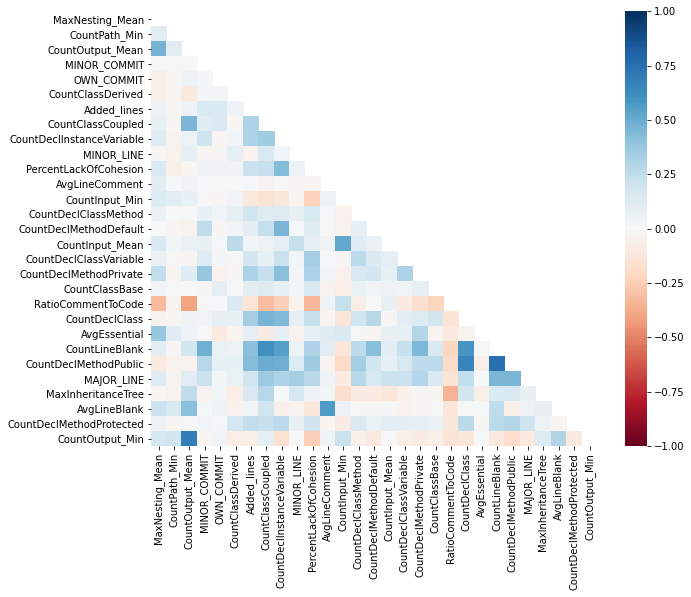

In [11]:
print('Correlation heatmap of software metrics that are selected by Step 1 of AutoSpearman')
generate_heatmap(X_AS)


*(Part 2) Automatically select non-correlated metrics based on a
Variance Inflation Factor analysis.* We first measure the magnitude of
multicollinearity of the remaining metrics ($M'$) from `Part 1` using
the Variance Inflation Factor analysis. We use a VIF
threshold value ($vif.t$) of 5 to identify the presence of
multicollinearity, as suggested by Fox {cite}`fox2015applied`.

To automatically remove correlated metrics from the Variance Inflation
Factor analysis, we identify the removed metric as the metric that has
the highest VIF score. We then exclude the removed
metric from the set of the remaining metrics ($M'$). We
apply the VIF analysis on the remaining metrics until none of the
remaining metrics have their VIF scores above or equal to the threshold
value. Finally,  produces a subset of non-correlated
metrics based on the Spearman rank correlation test and the VIF analysis
($M'$).

Similar to filter-based feature selection techniques, *Part 1*
of  measures the correlation of all metrics using the Spearman rank
correlation test regardless of model construction. Similar to
wrapper-based feature selection techniques, *Part 2* of  constructs
regression models to measure the magnitude of multicollinearity of
metrics. Thus, we consider  as a hybrid feature selection technique
(both filter-based and wrapper-based).


In [12]:

# Prepare a dataframe for VIF (Step 2) from the dataframe produced by (Step 1)
X_AS = add_constant(X_AS)

selected_features = X_AS.columns
count = 1
# (Part 2) Automatically select non-correlated metrics based on a Variance Inflation Factor analysis.
print('(Part 2) Automatically select non-correlated metrics based on a Variance Inflation Factor analysis')
while True:
    # Calculate VIF scores
    vif_scores = pd.DataFrame([variance_inflation_factor(X_AS.values, i) 
                   for i in range(X_AS.shape[1])], 
                  index=X_AS.columns)
    # Prepare a final dataframe of VIF scores
    vif_scores.reset_index(inplace = True)
    vif_scores.columns = ['Feature', 'VIFscore']
    vif_scores = vif_scores.loc[vif_scores['Feature'] != 'const', :]
    vif_scores.sort_values(by = ['VIFscore'], ascending = False, inplace = True)
    
    # Find features that have their VIF scores of above 5.0
    filtered_vif_scores = vif_scores[vif_scores['VIFscore'] >= 5.0]
    
    # Terminate when there is no features with the VIF scores of above 5.0
    if len(filtered_vif_scores) == 0:
        break
        
    # exclude the metric with the highest VIF score
    metric_to_exclude = list(filtered_vif_scores['Feature'].head(1))[0]
    
    print('Step', count,'- exclude', str(metric_to_exclude))
    count = count + 1
        
    selected_features = list(set(selected_features) - set([metric_to_exclude]))
    
    X_AS = X_AS.loc[:, selected_features]

print('According to Part 2, AutoSpearman selects the', len(AS_metrics), 'following metrics:')
set(AS_metrics) # alphabetically sorted

(Part 2) Automatically select non-correlated metrics based on a Variance Inflation Factor analysis
Step 1 - exclude CountLineBlank
According to Part 2, AutoSpearman selects the 29 following metrics:


{'Added_lines',
 'AvgEssential',
 'AvgLineBlank',
 'AvgLineComment',
 'CountClassBase',
 'CountClassCoupled',
 'CountClassDerived',
 'CountDeclClass',
 'CountDeclClassMethod',
 'CountDeclClassVariable',
 'CountDeclInstanceVariable',
 'CountDeclMethodDefault',
 'CountDeclMethodPrivate',
 'CountDeclMethodProtected',
 'CountDeclMethodPublic',
 'CountInput_Mean',
 'CountInput_Min',
 'CountLineBlank',
 'CountOutput_Mean',
 'CountOutput_Min',
 'CountPath_Min',
 'MAJOR_LINE',
 'MINOR_COMMIT',
 'MINOR_LINE',
 'MaxInheritanceTree',
 'MaxNesting_Mean',
 'OWN_COMMIT',
 'PercentLackOfCohesion',
 'RatioCommentToCode'}

### (Step 3) Model Construction

### (Step 4) Model Evaluation

### (Step 5) Model Ranking